In [1]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8


In [2]:
################################
# Start Dask Cluster (don't have to)
################################

import dask_gateway

cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(40)
print(cluster.dashboard_link)

/services/dask-gateway/clusters/prod.55a70531082444d5aec46cef2d8cb627/status


In [5]:
################################
# Read the dataset (only reads the metadata) - NORTH AMERICA
################################

# Ref: 
# https://daac.ornl.gov/DAYMET/guides/Daymet_Daily_V4.html#datasetoverview

import pystac
import fsspec
import xarray as xr

account_name = "daymeteuwest"
container_name = "daymet-zarr"

collection = pystac.Collection.from_file(
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/daymet-daily-na"
)
asset = collection.assets["zarr-https"]

store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])


In [6]:
ds['tmax']

<xarray.DataArray 'tmax' (time: 14965, y: 8075, x: 7814)>
dask.array<open_dataset-551569bd855fdfdaf531b1c5422c7560tmax, shape=(14965, 8075, 7814), dtype=float32, chunksize=(365, 284, 584), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(284, 584), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(284, 584), meta=np.ndarray>
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 2020-12-30T12:00:00
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
Attributes:
    cell_methods:  area: mean time: maximum
    grid_mapping:  lambert_conformal_conic
    long_name:     daily maximum temperature
    units:         degrees C

In [25]:
# How to write a func that returns iX,iY for given lat,lon ? -> still hard.
# ds.coords['lon'][4000,3000].values
df_lat = pd.DataFrame(ds.coords['lat'].values)
df_lon = pd.DataFrame(ds.coords['lon'].values)
lat_chicago = 41.881832
lon_chicago = -87.623177

In [46]:
# subset. otherwise takes too long

ds = ds.sel(time='1998')

In [47]:
%%time
################################
# Core algorithm - find heat extreme events for a SINGLE location
################################

# inputs: Dataset, iX, iY
# For a specific location (iX,iY), find all 'heat extreme' events defined by 
# two thresholds hardcoded as constants below.
# Return: a df of metadata, showing at what dates the event happened.
# Next, we can use this meta-data df to go back and crop that xarray & plot.

#############
# data
#############

# for a given input geo-location, e.g.
iX = 3000
iY = 4000

# slice the ND array and reduce it to a 2D xarray.DataArray:
tmax = ds['tmax'].isel(x=iX, y=iY) 

# extract the lat lon from Coordinates obj of the xarray.DataArray
lat = float(tmax.coords['lat'].values)
lon = float(tmax.coords['lon'].values)

# calc new xarray.DataArray's
tmax_avg = tmax.rolling(time=15, center=True).mean()
tmax_diff = tmax - tmax_avg

# convert all to pandas, i.e. pull small DataArray to single node's memory
df_tmax = pd.DataFrame(tmax.to_pandas())
df_avg = pd.DataFrame(tmax_avg.to_pandas())
df_diff = pd.DataFrame(tmax_diff.to_pandas())

#############
# algorithm
#############

# algorithm coefs:
TEMP_DIFF_THRESHOLD = 1 # Celcius (or K)
PERSISTED_FOR_MIN = 3 # days

df = pd.concat([df_tmax, df_avg, df_diff], axis=1)
df = df.sort_values(by='time') # just in case
df.columns = ['tmax', 'mov_avg', 'diff']
df = df.reset_index()

df['hot'] = df['diff'] > TEMP_DIFF_THRESHOLD # Celcius
# label is a counter that increases (only) when the value of column 'hot' changes
df['label'] = df['hot'].diff().ne(False).cumsum()
df = df.reset_index()
# e.g. for window size=15, drops 14 rows of nans from head and tail combined:
df = df.dropna(subset=['diff'])  
# select only the "hot" days (above moving average):
df = df[df['hot']]

#######
# group by label means group by consequtive blocks of 'heat' periods
#######

df = df.groupby('label').agg({
    'time':[np.min,np.max], 
    'tmax':[np.min,np.max], 
    'diff':[np.max,np.argmax]
}).reset_index()
df.columns = ['label', 'd1', 'd2', 'min_tmax', 'max_tmax', 'peak_diff', 'peak_day']

# I also saw many winter-heat-extremes (relative) - drop them
summer_months = [5,6,7,8,9]
df['isSummer'] = df['d1'].dt.month.isin(summer_months)
df = df[df['isSummer']]

# adjust for inclusive window, i.e. (] -> []
df['period'] = df['d2'] - df['d1'] + pd.Timedelta(1,'D') 

# find the index of the hottest day within each 'hot' window
df['d_peak'] = df['d1'] + pd.to_timedelta(df['peak_day'],'D')

# did the hot window took longer than a threshold, e.g. 3 days?
df['long'] = df['period'] >= pd.Timedelta(PERSISTED_FOR_MIN,'D')
df = df[df['long']]
df = df.drop(['long', 'label'], axis=1)
df = df.reset_index(drop=True)

# attach the meta data - repeats for the entire df
df['ix'] = iX
df['iy'] = iY
df['lat'] = lat
df['lon'] = lon

# formatting
df['d1'] = df['d1'].dt.date
df['d2'] = df['d2'].dt.date
df['d_peak'] = df['d_peak'].dt.date
col_order = "ix,iy,lat,lon,d1,d2,d_peak,peak_day,period,isSummer,min_tmax,max_tmax,peak_diff".split(",") 
df = df[col_order]
df

CPU times: user 154 ms, sys: 0 ns, total: 154 ms
Wall time: 5.46 s


,ix,iy,lat,lon,d1,d2,d_peak,peak_day,period,isSummer,min_tmax,max_tmax,peak_diff
0,3000,4000,49.742794,-122.843681,1998-05-31,1998-06-03,1998-06-03,3,4 days,True,14.560000,18.660000,3.956000
1,3000,4000,49.742794,-122.843681,1998-06-05,1998-06-08,1998-06-08,3,4 days,True,17.250000,26.030001,9.202666
2,3000,4000,49.742794,-122.843681,1998-06-20,1998-06-22,1998-06-21,1,3 days,True,21.320000,25.570000,12.616666
3,3000,4000,49.742794,-122.843681,1998-06-28,1998-07-02,1998-06-29,1,5 days,True,22.510000,29.840000,13.790665
4,3000,4000,49.742794,-122.843681,1998-07-07,1998-07-10,1998-07-10,3,4 days,True,20.370001,24.219999,8.651333
5,3000,4000,49.742794,-122.843681,1998-07-21,1998-07-29,1998-07-26,5,9 days,True,27.139999,36.349998,8.448666
6,3000,4000,49.742794,-122.843681,1998-08-12,1998-08-14,1998-08-13,1,3 days,True,21.190001,30.280001,11.076001
7,3000,4000,49.742794,-122.843681,1998-08-28,1998-09-05,1998-09-01,4,9 days,True,24.379999,32.310001,8.361334
8,3000,4000,49.742794,-122.843681,1998-09-14,1998-09-16,1998-09-15,1,3 days,True,18.520000,23.320000,6.996665
9,3000,4000,49.742794,-122.843681,1998-09-21,1998-09-23,1998-09-21,0,3 days,True,23.500000,24.629999,5.327330


In [97]:
# worst heat events (by tmax)
# df.sort_values('max_tmax', ascending=False).head()

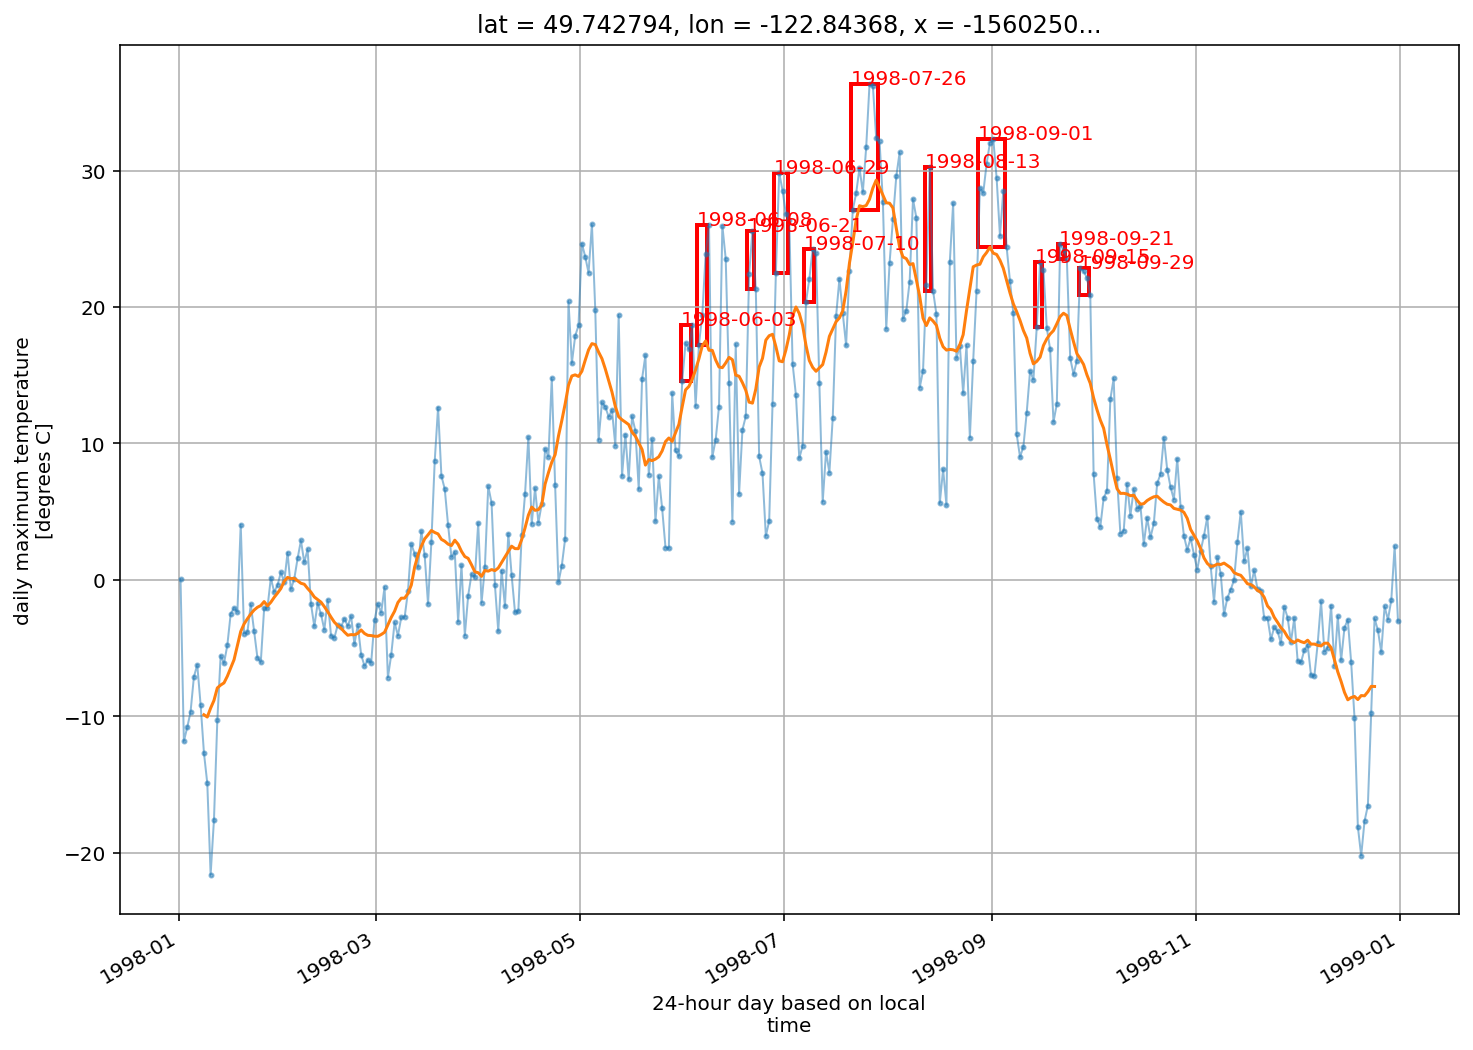

In [49]:
################################
# Plot the heat events, for a single fixed location
################################

# plot lines
tmax.plot(marker='o', markersize=2, linewidth=1, alpha=.5)
tmax_avg.plot()

# and add boxes for the detected-events
df_plot = df[df['d_peak'].apply(lambda x: str(x.year)) == '1998']

for i, row in df_plot[['d1','d2','d_peak','min_tmax','max_tmax']].iterrows():

    d1, d2, dp, temp_min, temp_max = row

    d1 = mdates.date2num(d1)
    d2 = mdates.date2num(d2)
    width = d2 - d1
    height = temp_max - temp_min
    
    rect = Rectangle((d1, temp_min), width, height, 
                     color='red', fill=False, linewidth=2)
    ax = plt.gca()
    ax.add_patch(rect)
    ax.text(d1, temp_max, dp, color='r')
    ax.grid(True)
    

CPU times: user 6.49 s, sys: 1.46 s, total: 7.94 s
Wall time: 21 s


Text(-1560250.0, 984000.0, 'lat=49.742794036865234\nlon=-122.84368133544922')

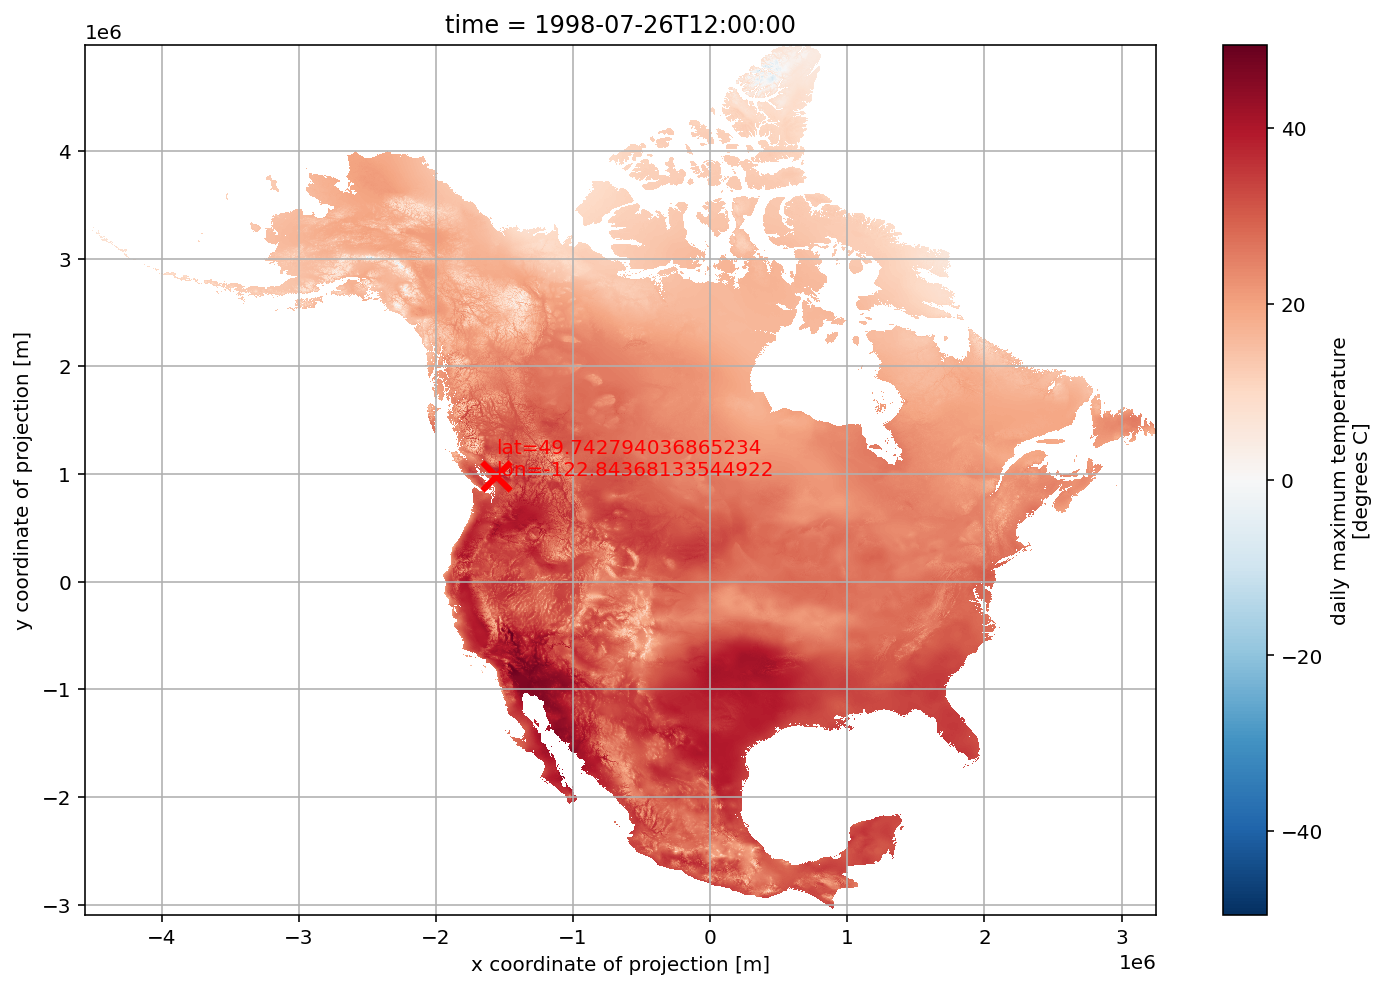

In [52]:
%%time
# Plot the grid at the day of one of the heat events above:

nTH = 5

lat, lon, d_peak = df_plot[['lat','lon','d_peak']].iloc[nTH]

ds['tmax'].sel(time=str(d_peak)).plot();

ax = plt.gca()
ax.grid(True)

x_projected = float(tmax.coords['x'].values)
y_projected = float(tmax.coords['y'].values)

ax.scatter(x_projected, y_projected, marker="x", s=200, c='r', linewidths=3);
ax.text(x_projected, y_projected, f"lat={lat}\nlon={lon}", color='r');